In [1]:
import pandas as pd
import numpy as np
import obspy
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import math

In [2]:
# Function to read and process the earthquake data
def read_earthquake_data(file_path):
    events = []
    observations = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                # Extracting event data
                parts = line.split()
                event = {
                    'id': int(parts[-1]),
                    'year': int(parts[1]),
                    'month': int(parts[2]),
                    'day': int(parts[3]),
                    'hour': int(parts[4]),
                    'minute': int(parts[5]),
                    'second': float(parts[6]),
                    'lat': float(parts[7]),
                    'lon': float(parts[8]),
                    'depth': float(parts[9]),
                    'magnitude': float(parts[10])
                }
                events.append(event)
            else:
                # Extracting observation data
                parts = line.split()
                observation = {
                    'event_id': events[-1]['id'],
                    'station': parts[0],
                    'travel_time': float(parts[1]),
                    'phase': parts[3]
                }
                observations.append(observation)
    return pd.DataFrame(events), pd.DataFrame(observations)

# Reading the station data
def read_station_data(file_path):
    stations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            station = {
                'station': parts[0],
                'lat': float(parts[1]),
                'lon': float(parts[2])
            }
            stations.append(station)
    return pd.DataFrame(stations)

# Read and process the data
eq_file_path = './ph2dt/hypoDD.pha'  # Replace with your file path
stations_file_path = './ph2dt/stations_hypoDD.dat'  # Replace with your file path

events_df, observations_df = read_earthquake_data(eq_file_path)
stations_df = read_station_data(stations_file_path)

# Merging the observations with the events and stations to get complete data
observations_merged = observations_df.merge(events_df, left_on='event_id', right_on='id')
observations_merged = observations_merged.merge(stations_df, on='station', how='left')

# Function to calculate distance between hypocenter and station
def calculate_hypocenter_distance(row):
    event_coords = (row['lat_x'], row['lon_x'])
    station_coords = (row['lat_y'], row['lon_y'])
    surface_distance = geodesic(event_coords, station_coords).kilometers
    # Pythagorean theorem to include depth
    total_distance = np.sqrt(surface_distance**2 + row['depth']**2)
    return total_distance

# Calculating hypocenter distances
observations_merged['hypocenter_distance'] = observations_merged.apply(calculate_hypocenter_distance, axis=1)

# Filtering the data for P-waves and S-waves only
p_wave_data = observations_merged[observations_merged['phase'] == 'P']
s_wave_data = observations_merged[observations_merged['phase'] == 'S']


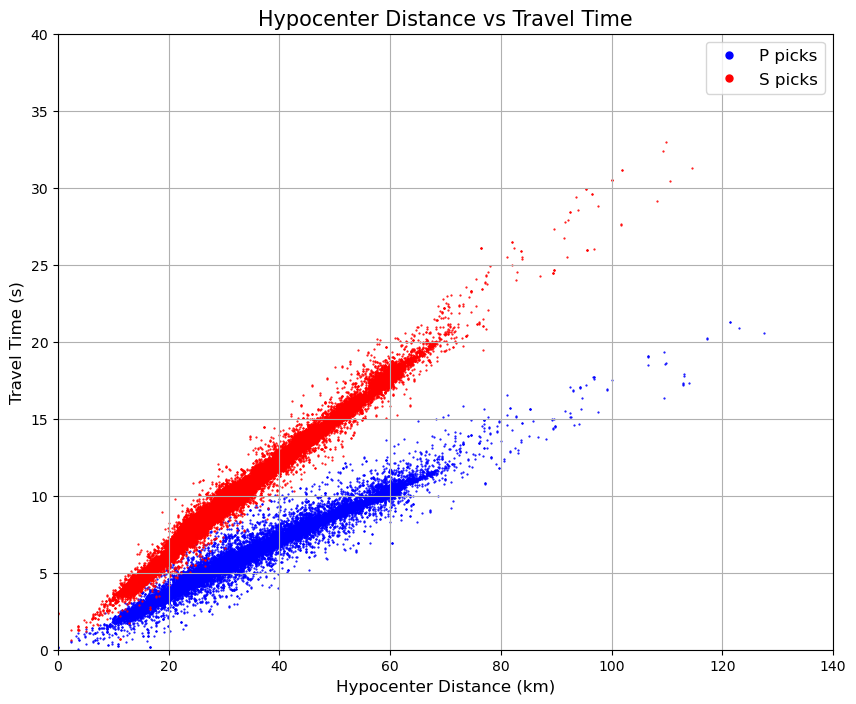

In [3]:
# Plotting Hypocenter Distance vs Travel Time
plt.figure(figsize=(10, 8))
plt.scatter(p_wave_data['hypocenter_distance'], p_wave_data['travel_time'], alpha=1, s=0.3, c='b')
plt.scatter(s_wave_data['hypocenter_distance'], s_wave_data['travel_time'], alpha=1, s=0.3, c='r')
plt.title('Hypocenter Distance vs Travel Time', size=15)
plt.xlabel('Hypocenter Distance (km)', size=12)
plt.ylabel('Travel Time (s)', size=12)
plt.grid(True)

plt.plot(500, 500, '.', markersize=10, label=f"P picks", c='b')
plt.plot(500, 500, '.', markersize=10, label=f"S picks", c='r')

plt.legend(fontsize=12)
plt.xlim(0,140)
plt.ylim(0,40)
plt.savefig("figures/hypocenter_tt.png", dpi=500)
plt.show()

# Relocated Hypocenters Distance

In [4]:
relocated_events = pd.read_csv("reloc.csv")
relocated_events.head()

,id,origin_time,lon,lat,depth,magnitude,rct
0,2,2019-07-04 17:02:55.080,-117.491626,35.711609,13.970,4.3,0.102
1,3,2019-07-04 17:04:02.360,-117.494873,35.706991,13.379,2.0,0.183
2,5,2019-07-04 17:05:01.680,-117.501099,35.706718,8.922,1.0,0.173
3,6,2019-07-04 17:05:05.160,-117.489071,35.711161,13.184,1.3,0.156
4,7,2019-07-04 17:05:47.880,-117.487158,35.710189,13.380,0.6,0.163


In [5]:
# Merging the observations with the events and stations to get complete data
reloc_merged = observations_df.merge(relocated_events, left_on='event_id', right_on='id')
reloc_merged = reloc_merged.merge(stations_df, on='station', how='left')

# Calculating hypocenter distances
reloc_merged['hypocenter_distance'] = reloc_merged.apply(calculate_hypocenter_distance, axis=1)

# Filtering the data for P-waves and S-waves only
p_wave_reloc = reloc_merged[reloc_merged['phase'] == 'P']
s_wave_reloc = reloc_merged[reloc_merged['phase'] == 'S']

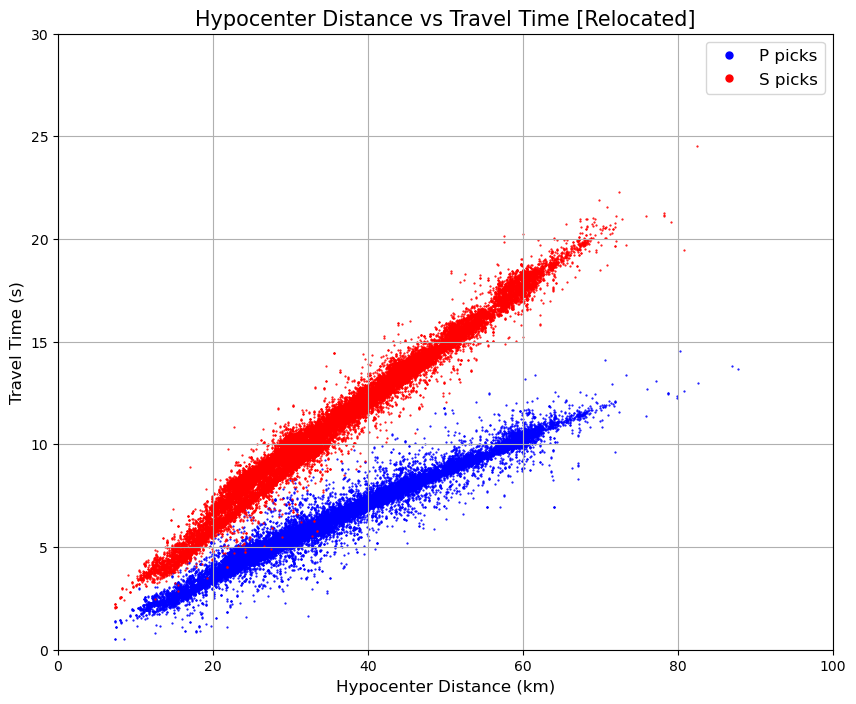

In [6]:
plt.figure(figsize=(10, 8))
plt.scatter(p_wave_reloc['hypocenter_distance'], p_wave_reloc['travel_time'], alpha=1, s=0.3, c='b')
plt.scatter(s_wave_reloc['hypocenter_distance'], s_wave_reloc['travel_time'], alpha=1, s=0.3, c='r')
plt.title('Hypocenter Distance vs Travel Time [Relocated]', size=15)
plt.xlabel('Hypocenter Distance (km)', size=12)
plt.ylabel('Travel Time (s)', size=12)
plt.grid(True)

plt.plot(500, 500, '.', markersize=10, label=f"P picks", c='b')
plt.plot(500, 500, '.', markersize=10, label=f"S picks", c='r')

plt.legend(fontsize=12)
plt.xlim(0,100)
plt.ylim(0,30)
plt.savefig("figures/hypocenter_RELOC.png", dpi=500)
plt.show()